# 0. Import library

In [2]:
library(cicero)

# 1. Prepare data
In this tutorial we'll use acATAC-seq data from the 10x genomics database.
You do not need to download these data if you analyze your own scATAC-seq data. 

In [4]:
# Create folder to store data
dir.create("data")

# Download demo dataset from 10x genomics 
system("wget -O data/matrix.tar.gz http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_E18_brain_fresh_5k/atac_v1_E18_brain_fresh_5k_filtered_peak_bc_matrix.tar.gz")

# Unzip data
system("tar -xvf data/matrix.tar.gz -C data")

In [6]:
# You can substitute the data path below with the data path of your scATAC data.
data_folder <- "data/filtered_peak_bc_matrix"

# Create a folder to save results
output_folder <- "cicero_output"
dir.create(output_folder)

# 2. Load data and make Cell Data Set (CDS) object 
## 2.1. Process data to make CDS object

In [7]:
# read in matrix data using the Matrix package
indata <- Matrix::readMM(paste0(data_folder, "/matrix.mtx")) 
# binarize the matrix
indata@x[indata@x > 0] <- 1

# format cell info
cellinfo <- read.table(paste0(data_folder, "/barcodes.tsv"))
row.names(cellinfo) <- cellinfo$V1
names(cellinfo) <- "cells"

# format peak info
peakinfo <- read.table(paste0(data_folder, "/peaks.bed"))
names(peakinfo) <- c("chr", "bp1", "bp2")
peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")
row.names(peakinfo) <- peakinfo$site_name

row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

# make CDS
input_cds <-  suppressWarnings(new_cell_data_set(indata,
cell_metadata = cellinfo,
gene_metadata = peakinfo))

input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

# 3. Qauality check and Filtering

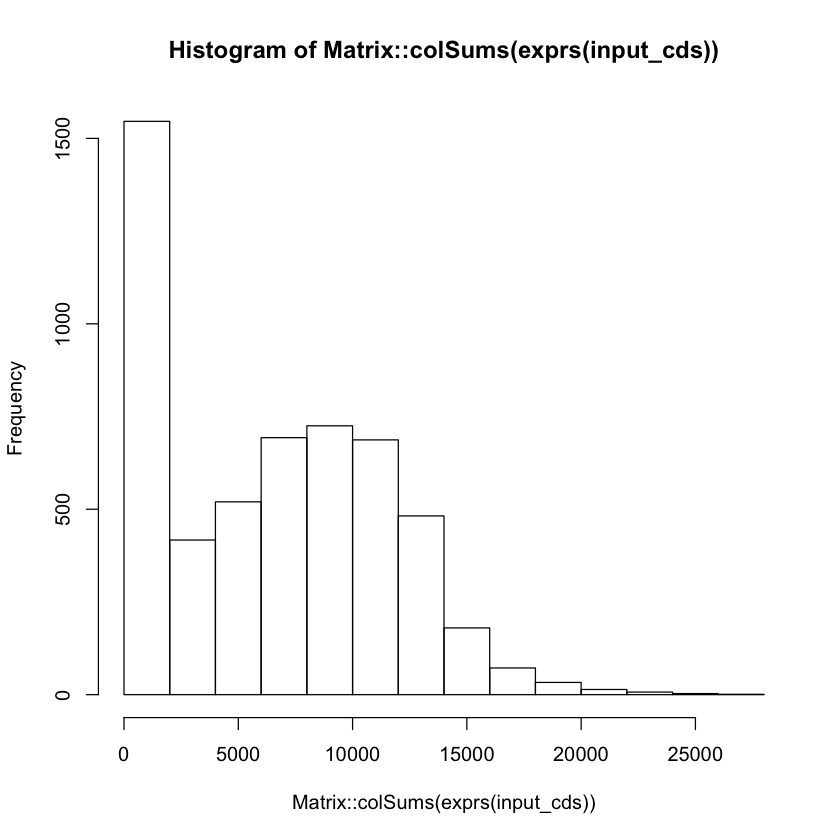

In [8]:
# Visualize peak_count_per_cell
hist(Matrix::colSums(exprs(input_cds)))

In [9]:
# filter cells by peak_count
# PLEASE SET APPROPRIATE THRESHOLD VALUES according to your data 
max_count <-  15000
min_count <- 2000
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) >= min_count] 
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) <= max_count] 


# 4. Process cicero-CDS object

In [ ]:
# Data preprocessing
set.seed(2017)

input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")

# Dimensional reduction with umap
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', 
                              preprocess_method = "LSI")
umap_coords <- reducedDims(input_cds)$UMAP


cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)

# Save cds object if you want
saveRDS(cicero_cds, paste0(output_folder, "/cicero_cds.Rds"))



# 5. Load reference genome information

To run cicero, we need to get a genome coordinates files, which contains the lengths of each chromosomes.
You can read mm10 genome information with the following command. 
The text file, mm10_chromosome_length.txt is included in the celloracle notebook folder.https://github.com/morris-lab/CellOracle/tree/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero

If your scATAC-seq data use different reference genome, you need to get a genome coordinates files for your reference genome. Please see the Cicero documentation for more information.https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero

In [ ]:
# !!Please make sure that the reference genome information below match the reference genome of your scATAC-seq data.

# If your scATAC-seq uses mm10 reference genome, you can read chromosome length file with the following command.
chromosome_length <- read.table("./mm10_chromosome_length.txt")

# For mm9 genome, you can use the following command.
#data("mouse.mm9.genome")
#chromosome_length <- mouse.mm9.genome

# For hg19 genome, you can use the following command.
#data("human.hg19.genome")
#chromosome_length <- mhuman.hg19.genome



# 6. Run Cicero

In [11]:
# runc the main function
conns <- run_cicero(cicero_cds, chromosome_length) # Takes a few minutes to run

# save results
saveRDS(conns, paste0(output_folder, "/cicero_connections.Rds"))

# check results
head(conns)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Done"


,Peak1,Peak2,coaccess
,<fct>,<fct>,<dbl>
2,chr1_3094484_3095479,chr1_3113499_3113979,-0.316289004
3,chr1_3094484_3095479,chr1_3119478_3121690,-0.419240532
4,chr1_3094484_3095479,chr1_3399730_3400368,-0.050867246
5,chr1_3113499_3113979,chr1_3094484_3095479,-0.316289004
7,chr1_3113499_3113979,chr1_3119478_3121690,0.370342744
8,chr1_3113499_3113979,chr1_3399730_3400368,-0.009276026


# 6. Save results for the next step

In [ ]:
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(output_folder, "/all_peaks.csv"))
write.csv(x = conns, file = paste0(output_folder, "/cicero_connections.csv"))
